# User Based Collaborative Filtering 

In [1]:
# ideas from 
# https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3
# https://github.com/krishnaik06/Recommendation_complete_tutorial/blob/master/KNN%20Movie%20Recommendation/KNNRecommendation.ipynb
# https://www.sciencedirect.com/science/article/pii/S0924224415002873
# http://www.ra.ethz.ch/CDstore/www10/papers/pdf/p519.pdf

In [1]:
import os
import pandas as pd
import numpy as np
import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the data
dataset_directory="Dataset"
train_name = "train_split.csv"
test_name = "test_split.csv"

train = pd.read_csv(f"../{dataset_directory}/{train_name}")
test = pd.read_csv(f"../{dataset_directory}/{test_name}")

FileNotFoundError: [Errno 2] No such file or directory: '../Dataset/train_split.csv'

In [3]:
train.drop(columns='Unnamed: 0', inplace = True)
test.drop(columns='Unnamed: 0', inplace = True)
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]

# ingredients = X_train.columns.values

In [4]:
X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1:]

### Model

In [5]:
X_train_matrix = sparse.csr_matrix(X_train)
model_knn_cosine = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn_hamming = NearestNeighbors(metric = 'hamming', algorithm = 'brute')
model_knn_jaccard = NearestNeighbors(metric = 'jaccard', algorithm = 'brute')

In [6]:
model_knn_cosine.fit(X_train_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

### Functions

In [10]:
def get_recipe(recipe_index, X):
    '''
    Get the recipe vector and its ingredients 
    '''
    # get recipe
    recipe_vector = X.loc[recipe_index].copy(deep=True)

    # Get ingredients of the recipe
    recipe_ing = recipe_vector[recipe_vector >0].index.values
    
    return recipe_vector, recipe_ing

In [11]:
def remove_ingredient(recipe_vector, recipe_ing):
    '''
    Randomly remove an ingredient of a recipe
    '''
    # randomly remove an ingredient
    ingredient_removed = np.random.choice(recipe_ing)
    recipe_vector_r = recipe_vector
    recipe_vector_r[ingredient_removed] = 0
    
    # Get ingredients of the recipe with removed ingredient
    recipe_ing_r = recipe_vector_r[recipe_vector_r >0].index.values

    return ingredient_removed, recipe_vector_r, recipe_ing_r

In [12]:
def predict_recipe(recipe_vector_r, model, n_neighbors):
    '''
    predict similar recipes 
    '''
     
    # find the neighbours, get the distance, and index of the recipes 
    distances, indices = model.kneighbors(recipe_vector_r.values.reshape(1,-1), n_neighbors = n_neighbors)
    
    distances = distances.flatten()
    indices = indices.flatten()
    
    return distances, indices

In [13]:
def get_ingredients(indices, X, recipe_ing_r):
    '''
    From the similar recipes, we get the ingredients, and remove the ingredients existing in the partial recipe. 
    Then, sort it based on frequency. 
    '''
    
    ingredients_recommended = []
    
    # get the ingredients for all similar recipes
    for index in indices: 
        recipe_vector, recipe_ing = get_recipe(index, X)
        ingredients_recommended.append(recipe_ing)

    ingredients_recommended = [item for sublist in ingredients_recommended for item in sublist]
    ingredients_recommended = pd.DataFrame(ingredients_recommended, columns = ['ingredients'])
    ingredients_recommended['count'] = 1
    ingredients_recommended = ingredients_recommended.groupby(by = ['ingredients']).sum()
    
    # remove the existing ingredients from the recommendation.
    for ing in ingredients_recommended.index:
        if ing in recipe_ing_r:
            ingredients_recommended = ingredients_recommended.drop(ing)
    
    # sort based on frequency
    ingredients_recommended = ingredients_recommended.sort_values(by = ['count'], ascending = False)
    
    return ingredients_recommended

In [14]:
def add_recall(ingredient_removed, ingredients_recommended, recall_count): 
    '''
    If the missing ingredient is present in the top 10 recommended ingredients, set recall_count += 1
    
    '''

    if ingredient_removed in ingredients_recommended.nlargest(10, columns = 'count').index.values: 
        recall_count += 1
        
    return recall_count

### Recommendation for one recipe - have fun :) 

In [15]:
recipe_index = 100
recipe_vector, recipe_ing = get_recipe(recipe_index, X_train)
ingredient_removed, recipe_vector_r, recipe_ing_r = remove_ingredient(recipe_vector, recipe_ing)
distances, indices = predict_recipe(recipe_vector_r, model_knn_cosine, 10)
ingredients_recommended = get_ingredients(indices, X_train, recipe_ing_r)
recall_count = 0
recall_count = add_recall(ingredient_removed, ingredients_recommended, recall_count)

In [16]:
print('Cuisine:', y_train.iloc[recipe_index].values)
print('Ingredients:', recipe_ing)
print('Ingredient_removed:', ingredient_removed)
print ('Present in top 10 recommended ingredient:', ingredient_removed in ingredients_recommended.nlargest(10, columns = 'count').index.values)
ingredients_recommended.head(10)

Cuisine: [2]
Ingredients: ['butter' 'garlic' 'heavy cream' 'parmesan cheese' 'pasta' 'shallot'
 'sour cream' 'wine']
Ingredient_removed: sour cream
Present in top 10 recommended ingredient: True


count
ingredients         
olive oil          4
salt               2
tomato             2
pepper             2
parsley            2
prosciutto         2
broth              2
sour cream         1
smoked salmon      1
shrimp             1

In [15]:
# Split data for cross validation 
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X_train, y_train)

5

## Cross Validation using Train Data

### Cosine Metric

In [253]:
%%time
# choosing hyperparameter (number of neighbours) using cross validation  
model = model_knn_cosine
n_neighbours = [5, 10, 25, 50, 75, 100, 200, 500, 700]
recall_cvscore_cosine = []

for n in n_neighbours:

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # fit
        X_train_fold_matrix = sparse.csr_matrix(X_train_fold)
        model_knn_cosine.fit(X_train_fold_matrix)

        recall_count = 0
        recall_score = []

        for recipe in X_test_fold.index.values:
            recipe_index = recipe
            recipe_vector, recipe_ing = get_recipe(recipe_index, X_test_fold)
            ingredient_removed, recipe_vector_r, recipe_ing_r = remove_ingredient(recipe_vector, recipe_ing)
            distances, indices = predict_recipe(recipe_vector_r, model, n)
            ingredients_recommended = get_ingredients(indices, X_train, recipe_ing_r)

            recall_count = add_recall(ingredient_removed, ingredients_recommended, recall_count)

        recall_score.append(recall_count/len(X_test_fold))

    recall_cvscore_cosine.append(np.array(recall_score).mean())

print(recall_cvscore_cosine)

[0.48672566371681414, 0.5026548672566372, 0.5433628318584071, 0.5451327433628319, 0.5097345132743363, 0.5415929203539823, 0.4743362831858407, 0.42123893805309737, 0.4407079646017699]
Wall time: 27min 23s


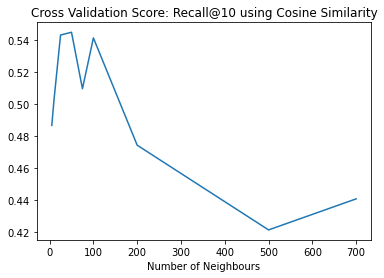

In [254]:
# plot the number of neighbours vs recall score
# 1.0 means 100% of the time the missing ingredients are present in the to 10 recommended ingredients 
plt.plot([5, 10, 25, 50, 75, 100, 200, 500, 700], recall_cvscore_cosine)
plt.title("Cross Validation Score: Recall@10 using Cosine Similarity")
plt.xlabel('Number of Neighbours')

plt.show()

### Hamming Metric

In [252]:
%%time
# choosing hyperparameter (number of neighbours) using cross validation  
model = model_knn_hamming
n_neighbours = [5, 10, 25, 50, 75, 100, 200, 500, 700]
recall_cvscore_hamming = []

for n in n_neighbours:

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # fit
#         X_train_fold_matrix = sparse.csr_matrix(X_train_fold)
        model.fit(X_train_fold)

        recall_count= 0
        recall_score = []

        for recipe in X_test_fold.index.values:
            recipe_index = recipe
            recipe_vector, recipe_ing = get_recipe(recipe_index, X_test_fold)
            ingredient_removed, recipe_vector_r, recipe_ing_r = remove_ingredient(recipe_vector, recipe_ing)
            distances, indices = predict_recipe(recipe_vector_r, model, n)
            ingredients_recommended = get_ingredients(indices, X_train, recipe_ing_r)

            recall_count = add_recall(ingredient_removed, ingredients_recommended, recall_count)

        recall_score.append(recall_count/len(X_test_fold))

    recall_cvscore_hamming.append(np.array(recall_score).mean())

print(recall_cvscore_hamming)

[0.3893805309734513, 0.4690265486725664, 0.4902654867256637, 0.5150442477876106, 0.5097345132743363, 0.49911504424778763, 0.5185840707964602, 0.4389380530973451, 0.4194690265486726]
Wall time: 33min 50s


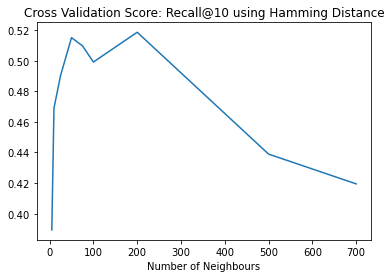

In [255]:
# plot the number of neighbours vs recall score
# 1.0 means 100% of the time the missing ingredients are present in the to 10 recommended ingredients 
plt.plot([5, 10, 25, 50, 75, 100, 200, 500, 700], recall_cvscore_hamming)
plt.title("Cross Validation Score: Recall@10 using Hamming Distance")
plt.xlabel('Number of Neighbours')

plt.show()

### Jaccard Metric

In [256]:
%%time
# choosing hyperparameter (number of neighbours) using cross validation  
model = model_knn_jaccard
n_neighbours = [5, 10, 25, 50, 75, 100, 200, 500, 700]
recall_cvscore_jaccard = []

for n in n_neighbours:

    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # fit
#         X_train_fold_matrix = sparse.csr_matrix(X_train_fold)
        model.fit(X_train_fold)

        recall_count= 0
        recall_score = []

        for recipe in X_test_fold.index.values:
            recipe_index = recipe
            recipe_vector, recipe_ing = get_recipe(recipe_index, X_test_fold)
            ingredient_removed, recipe_vector_r, recipe_ing_r = remove_ingredient(recipe_vector, recipe_ing)
            distances, indices = predict_recipe(recipe_vector_r, model, n)
            ingredients_recommended = get_ingredients(indices, X_train, recipe_ing_r)

            recall_count = add_recall(ingredient_removed, ingredients_recommended, recall_count)

        recall_score.append(recall_count/len(X_test_fold))

    recall_cvscore_jaccard.append(np.array(recall_score).mean())

print(recall_cvscore_jaccard)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

[0.45663716814159294, 0.49734513274336284, 0.5734513274336284, 0.5628318584070796, 0.5592920353982301, 0.5380530973451327, 0.479646017699115, 0.4407079646017699, 0.44601769911504424]
Wall time: 29min 56s


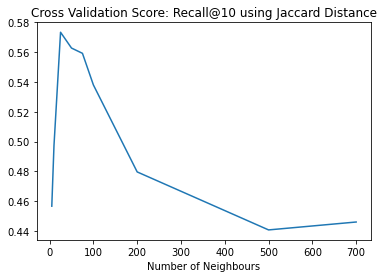

In [257]:
# plot the number of neighbours vs recall score
# 1.0 means 100% of the time the missing ingredients are present in the to 10 recommended ingredients 
plt.plot([5, 10, 25, 50, 75, 100, 200, 500, 700], recall_cvscore_jaccard)
plt.title("Cross Validation Score: Recall@10 using Jaccard Distance")
plt.xlabel('Number of Neighbours')

plt.show()

### Combined

In [17]:
### read the results saved as csv 
# cvscores = pd.read_csv('cv_results_user_based.csv')
# recall_cvscore_cosine = cvscores['cosine']
# recall_cvscore_hamming = cvscores['hamming']
# recall_cvscore_jaccard = cvscores['jaccard']

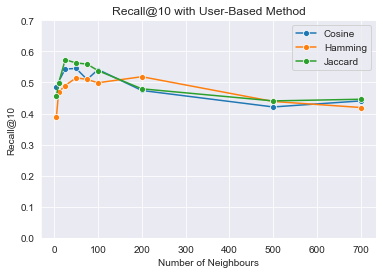

In [18]:
# plot the number of neighbours vs recall score
# 1.0 means 100% of the time the missing ingredients are present in the to 10 recommended ingredients 
sns.set_style("darkgrid")
n_neighbours = [5, 10, 25, 50, 75, 100, 200, 500, 700]
sns.lineplot(x = n_neighbours, y = recall_cvscore_cosine, marker = 'o', label = 'Cosine')
sns.lineplot(x = n_neighbours, y = recall_cvscore_hamming, marker = 'o', label = 'Hamming')
sns.lineplot(x = n_neighbours, y = recall_cvscore_jaccard, marker = 'o', label = 'Jaccard')
plt.title("Recall@10 with User-Based Method")
plt.xlabel('Number of Neighbours')
plt.ylim(0, 0.7)
plt.ylabel('Recall@10')

plt.show()
# plt.savefig('cv_results_user_based.pdf')

##  Deploy Using the Best Performing Distance Metric 
To obtain the generalized performance, we train on the entire training set, and test the performance on the test set. Therefore the recipes in the test set are recipes "not seen" before. Note that np.random.choice is used in the function `remove_ingredient`, therefore the performance may vary slightly when the code below is re-run. 

In [333]:
%%time
model = model_knn_jaccard
n_neighbours = 25

# fit
model.fit(X_train)

recall_count= 0
recall_score = []

for recipe in X_test.index.values:
    recipe_index = recipe
    recipe_vector, recipe_ing = get_recipe(recipe_index, X_test)
    ingredient_removed, recipe_vector_r, recipe_ing_r = remove_ingredient(recipe_vector, recipe_ing)
    distances, indices = predict_recipe(recipe_vector_r, model, n)
    ingredients_recommended = get_ingredients(indices, X_train, recipe_ing_r)

    recall_count = add_recall(ingredient_removed, ingredients_recommended, recall_count)

recall_score.append(recall_count/len(X_test))

recall_final_jaccard = (np.array(recall_score).mean())

print(recall_final_jaccard)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\User\anaconda3\lib\site-package

0.4534842589317297
Wall time: 12min 41s


In [316]:
### save results and export to csv
# cv_results = pd.DataFrame(np.array(n_neighbours), columns = ['n_neighbours'])
# cv_results['cosine'] = recall_cvscore_cosine
# cv_results['hamming'] = recall_cvscore_hamming
# cv_results['jaccard'] = recall_cvscore_jaccard
# performance_results = pd.DataFrame([25], columns = ['n_neighbours'])
# performance_results['jaccard'] = recall_final_jaccard

# cv_results.to_csv('cv_results_user_based.csv')
# performance_results.to_csv('performance_results_user_based.csv')

## Conclusion
1. Here, we use recall@10 as performance measure. Recall@10 is the percentage of the number of times the missing ingredient is present in the top 10 recommended ingredients.
2. Best performing distance measure is jaccard distance with 25 neighbours 
3. Generalized performance, based on Recall@10 = 46%